In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sys
sys.path.append('synthetic_data/')
import synthetic_data_generation as sdg
import normalization as norm
import pickle

# Sample Noisy Data

In [16]:
# define time points of toy model
timepoints   = np.linspace(0,15,20)
n_timepoints = len(timepoints)
# set seed of rng
np.random.seed(13)
n_replicates = 100
# we want 100 metabolites and exclude the first 4 toy model ones later
n_metabolites  = 104
error_sigma    = .2
toy_parameters = np.array([[2,.1,1,0,.1],
                           [2,.1,2,0,.1],
                           [2,.1,3,0,.1],
                           [2,.1,.5,0,.1]])
    
noise_levels = [20,30,40,50,60,80,100,150,200,300,400,500,600,700,800,900,1000,2000,3000]
# sample sv and e
sv_t_list, sv_v_list = sdg.generate_sweat_volumes(n_replicates,n_metabolites,n_timepoints)
e_list               = sdg.generate_experimental_errors(n_replicates,n_metabolites,n_timepoints,error_sigma)
results = {}
for n_replicate in range(n_replicates):
    PQNs = {}
    sv_tensor = sv_t_list[n_replicate]
    sv_vector = sv_v_list[n_replicate]
    e_tensor  = e_list[n_replicate]
    # get concentration values
    c_tensor = sdg.generate_random_from_real_data(4,n_metabolites,toy_parameters,timepoints,'unused')
    # calculate M_tilde
    m_tensor     = c_tensor * sv_tensor * e_tensor
    # exclude the first 4 toy model metabolites for this analysis
    m_tensor = m_tensor[4:,:]
    # calculate the PQN when there is no noise --> very exact result
    PQNs[0] = norm.calculate_pqn(m_tensor)
    # test different levels of additional noisy metabolites (i.e. background signal).
    for n_noise in noise_levels:
        noise_tensor = sdg.generate_random_from_real_data(4,n_noise+4,toy_parameters,timepoints,'unused')[4:,:]
        combined_tensor = np.vstack([m_tensor,noise_tensor])
        PQNs[n_noise] = norm.calculate_pqn(combined_tensor)
    # save everything in a dictionary.
    results[n_replicate] = PQNs
to_file = sv_v_list, results
with open(f'noisy_pqn.pkl','wb') as file:
    pickle.dump(to_file,file)

# Plot CV of PQN time series

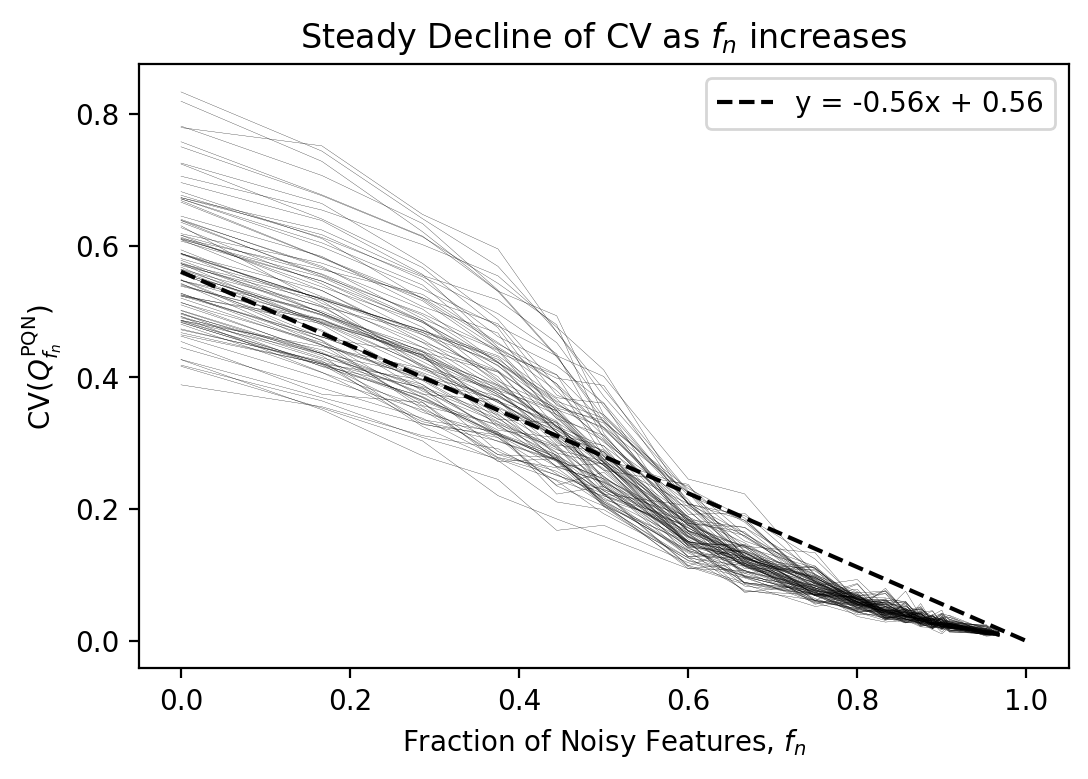

In [17]:
with open(f'noisy_pqn.pkl','rb') as file:
    sv_v_list, results = pickle.load(file)
    
def cv(array):
    return np.std(array)/np.mean(array)

def lin(x,k):
    y = -k*x+k
    return y

from scipy.optimize import curve_fit

plt.figure(dpi=200)
plt.title(r'Steady Decline of CV as $f_n$ increases')
all_x = np.array([])
all_y = np.array([])
for n_replicate in results:
    n_noisy_features = []
    pqn_cv = []
    tmpPQN = results[n_replicate]
    for n_noise in tmpPQN:
        n_noisy_features.append(n_noise)
        pqn_cv.append(cv(tmpPQN[n_noise]))
        pass
    tmp_x = np.array(n_noisy_features)/(np.array(n_noisy_features)+n_metabolites-4)
    tmp_y = pqn_cv
    all_x = np.concatenate([all_x,tmp_x])
    all_y = np.concatenate([all_y,tmp_y])
    plt.plot(tmp_x,tmp_y,color='k',linewidth=.1)
    
p, cov = curve_fit(
    f = lin,
    xdata = all_x,
    ydata = all_y
)
syn_x = np.linspace(0,1,100)
syn_y = lin(syn_x,*p)
plt.plot(syn_x,syn_y,'k--',label='y = -{:.2f}x + {:.2f}'.format(p[0],p[0]))
plt.legend()
plt.xlabel(r'Fraction of Noisy Features, $f_n$')
plt.ylabel(r'CV($Q^{\rm PQN}_{f_n}$)')
plt.show()

# Plot error of PQN and Z(PQN) at different Noise Levels

In [39]:
def standard_scale(array):
    z = (array-np.mean(array))/np.std(array)
    return z

def mean_scaled(array):
    m = array/np.mean(array)
    return m

comp_abs = {}
comp_sca = {}
for n_noise in [0]+noise_levels:
    comp_abs[n_noise] = []
    comp_sca[n_noise] = []

for n_replicate in results:
    tmp = results[n_replicate]
    for n_noise in tmp:
        comp_abs[n_noise].append(np.sum(np.abs(   mean_scaled(tmp[n_noise])-    mean_scaled(sv_v_list[n_replicate]))))
        comp_sca[n_noise].append(np.sum(np.abs(standard_scale(tmp[n_noise])-standard_scale(sv_v_list[n_replicate])))*np.std(sv_v_list))
#     break

abs_means = []
sca_means = []
abs_std = []
sca_std = []
for n_noise in comp_abs:
    abs_means.append(np.mean(comp_abs[n_noise]))
    sca_means.append(np.mean(comp_sca[n_noise]))
    abs_std.append(np.std(comp_abs[n_noise]))
    sca_std.append(np.std(comp_sca[n_noise]))

fn_list = np.array(list(comp_abs.keys()))/(100+np.array(list(comp_abs.keys())))

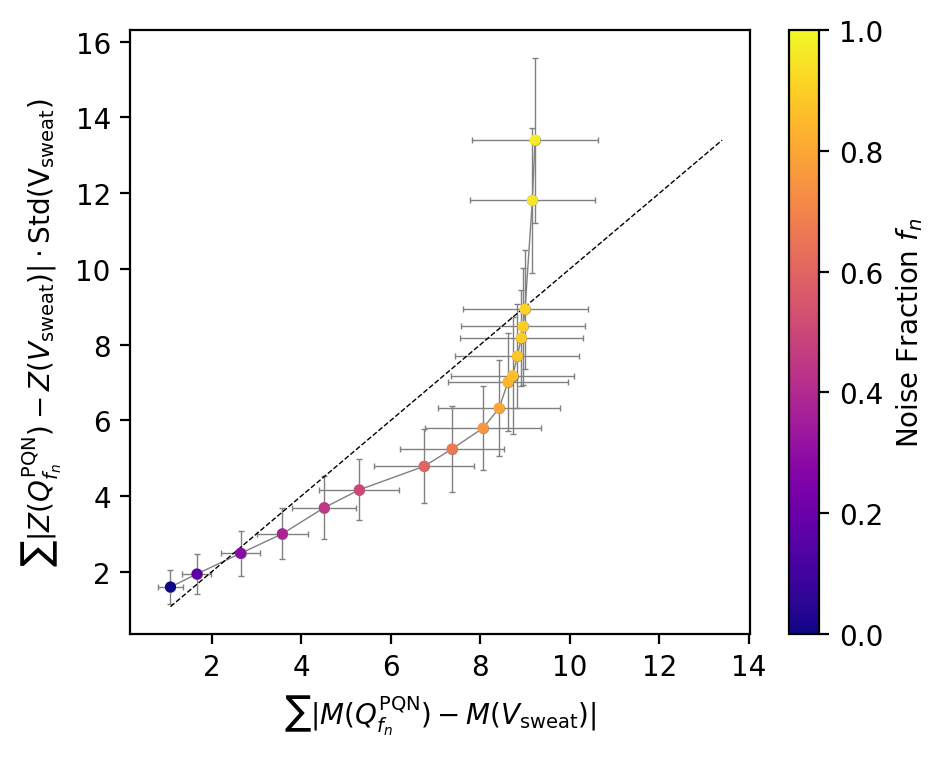

In [40]:
def options_plot_identiy(*some_arrays,color='k',linestyle='--',linewidth=1,label=False):
    tmp_min = np.min(some_arrays)
    tmp_max = np.max(some_arrays)
    if label:
        plt.plot([tmp_min,tmp_max],[tmp_min,tmp_max],color=color,linestyle=linestyle,linewidth=linewidth,label='Identity')
    else:
        plt.plot([tmp_min,tmp_max],[tmp_min,tmp_max],color=color,linestyle=linestyle,linewidth=linewidth)

plt.figure(dpi=200,figsize=(5,4))
plt.plot(abs_means,sca_means,color='grey',linewidth=.5)
for i in range(len(abs_means)):
    plt.errorbar(abs_means[i],sca_means[i],yerr=sca_std[i],xerr=abs_std[i],marker='.',zorder=0,color='grey',linewidth=.5,capsize=1,capthick=.5)
options_plot_identiy(abs_means,sca_means,linewidth=.5,label=True)
plt.xlabel(r'$\sum |M(Q^{\rm PQN}_{f_n})-M(V_{\rm sweat})|$')
plt.ylabel(r'$\sum |Z(Q^{\rm PQN}_{f_n})-Z(V_{\rm sweat})| \cdot \rm Std(V_{\rm sweat})$')
points = plt.scatter(abs_means,sca_means,marker='.',zorder=5,color=cm.plasma(fn_list))
plt.colorbar(mappable=cm.ScalarMappable(cmap='plasma'),label=r'Noise Fraction $f_n$')
plt.show()

In [49]:
print(r'$f_n$ where M(PQN) is better than Z(PQN):')
for i in fn_list[np.array(abs_means) < np.array(sca_means)]:
    print('{:.2f}'.format(i))
print(r'$f_n$ where Z(PQN) is better than M(PQN):')
for i in fn_list[np.array(abs_means) > np.array(sca_means)]:
    print('{:.2f}'.format(i))

$f_n$ where M(PQN) is better than Z(PQN):
0.00
0.17
0.95
0.97
$f_n$ where Z(PQN) is better than M(PQN):
0.29
0.38
0.44
0.50
0.60
0.67
0.75
0.80
0.83
0.86
0.88
0.89
0.90
0.91
